In [1]:
from torchvision import utils
from basic_fcn import *
from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

In [2]:
batch = 4
train_dataset = CityScapesDataset(csv_file='train.csv')
val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch,
                          num_workers=4,
                          shuffle=True)

In [3]:
# Inspect DataLoader objects
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 2975
Number of validation examples: 500
Number of test examples: 1525


In [4]:
# Look at a dataset data
example = train_dataset[0]
print("Training set example image file:", train_dataset.data.iloc[0][0])
print("Training set example label file:", train_dataset.data.iloc[0][1])
print("Size of the image tensor:", example[0].size())
print("Size of the one-hot target tensor:", example[1].size())
print("Size of the label tensor:", example[2].size())
print(example[2])

Training set example image file: /datasets/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
Training set example label file: /datasets/cityscapes/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
Size of the image tensor: torch.Size([3, 1024, 2048])
Size of the one-hot target tensor: torch.Size([34, 1024, 2048])
Size of the label tensor: torch.Size([1024, 2048])
tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


In [5]:
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched[0].size())
    print(sample_batched[1].size())
    print(sample_batched[2].size())
    break

torch.Size([4, 3, 1024, 2048])
torch.Size([4, 34, 1024, 2048])
torch.Size([4, 1024, 2048])


In [6]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.xavier_uniform_(m.bias.data.unsqueeze(0)) #add unsqueeze here 
        
epochs     = 1
criterion = nn.CrossEntropyLoss()
fcn_model = FCN(n_class=n_class)
fcn_model.apply(init_weights)
#fcn_model = torch.load('best_model')
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

In [7]:
print("Current memory allocation:", torch.cuda.memory_allocated())

Current memory allocation: 0


In [8]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    fcn_model = fcn_model.cuda()

In [9]:
def train():
    t_losses = []
    t_accuracies = []
    val_losses = []
    val_accuracies = []
    ious = []
    
    for epoch in range(0, epochs+1):
        
        print("Training Epoch {}".format(epoch))
        ts = time.time()
        
        numIter = 0
        epoch_train_loss = 0
        epoch_train_acc = 0
        
        for iter, (X, tar, Y) in enumerate(train_loader):
            numIter +=1
            optimizer.zero_grad()

            if use_gpu:
                torch.cuda.empty_cache() 
                inputs = X.cuda() # Move your inputs onto the gpu
                labels = Y.cuda()
            else:
                inputs, labels = X, Y # Unpack variables into inputs and labels

            outputs = fcn_model(inputs)
            del inputs
            
            loss = criterion(outputs, labels)            
            epoch_train_loss += loss.item()
            
            speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
            del outputs
            
            indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension
            del(speakSoftlyAndCarryABigStick)
            
            epoch_train_acc += pixel_acc(indexes, labels)
            del indexes, labels
            
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()    
            
            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
                  
            #'''
            if iter == 10:
                break
            #'''
              
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        print("Current memory allocation:", torch.cuda.memory_allocated()) 
        
        #torch.save(fcn_model, 'best_model')
        print()
        
        t_losses.append(epoch_train_loss/numIter)
        t_accuracies.append(epoch_train_acc/numIter)
        
        val_loss, val_acc, iou = val(epoch)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        ious.append(iou)
        fcn_model.train()
        
    return t_losses, t_accuracies, val_losses, val_accuracies, ious

def val(epoch):

    print("Validation Epoch {}".format(epoch+1))
    
    fcn_model.eval()
    valLoss = 0
    valAcc = 0
    numIter = 0
    soMuchTension = torch.Tensor([0 for i in range(n_class)]) #intersection
    theresATigerInTheBathroom = torch.Tensor([0 for i in range(n_class)]) #union
    ts = time.time()
    
    for iter, (X, tar, Y) in enumerate(val_loader):
        numIter +=1
        if use_gpu:
            torch.cuda.empty_cache() 
            inputs = X.cuda()
            labels = Y.cuda()
        else:
            inputs, labels = X, Y
            
        outputs = fcn_model(inputs)
        valLoss += criterion(outputs, labels).item()   
        speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1) #softmax along the number of class dimension
        del inputs, outputs
        
        indexes = torch.argmax(speakSoftlyAndCarryABigStick, dim = 1) #get the argmax along the channel dimension      
        del speakSoftlyAndCarryABigStick
        
        valAcc += pixel_acc(indexes, labels)
        theEyesHaveIt, spaceBalls = iou(indexes, labels, n_class) #intersection, union
        del labels, indexes
        
        soMuchTension = soMuchTension + theEyesHaveIt
        del theEyesHaveIt
        
        theresATigerInTheBathroom = theresATigerInTheBathroom + spaceBalls
        del spaceBalls
      
        iOweYouMoney = torch.div(soMuchTension, theresATigerInTheBathroom)
        
        torch.cuda.empty_cache()
        #'''
        if iter == 2:
            break
        #'''    
    del soMuchTension, theresATigerInTheBathroom
    
    print()
    valAcc = valAcc/numIter
    valLoss = valLoss/numIter
    print("epoch{}, validation loss: {}".format(epoch+1, valLoss))
    print("epoch{}, validation accuracy: {}".format(epoch+1, valAcc))
    print("The building IOU is: " + str(iOweYouMoney[11].item()))
    print("The traffic sign IOU is: " + str(iOweYouMoney[20].item()))
    print("The person IOU is: " + str(iOweYouMoney[24].item()))
    print("The car IOU is: " + str(iOweYouMoney[26].item()))
    print("The bicycle IOU is: " + str(iOweYouMoney[33].item()))
    print("The average IOU is: " + str(MeanIOU(iOweYouMoney)))
    print("Finish validation at epoch{}, time elapsed {}".format(epoch+1, time.time() - ts))
    print("Current memory allocation:", torch.cuda.memory_allocated())
    print()
    return valLoss, valAcc, iOweYouMoney
    
def test():
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    speakSoftlyAndCarryABigStick = F.softmax(outputs, dim = 1)
    
if __name__ == "__main__":
    validation0 = val(-1)  # show the accuracy before training
    training_losses, training_accuracies, validation_losses, validation_accuracies, validation_ious = train()
    validation_losses.insert(0, validation0[0])
    validation_accuracies.insert(0, validation0[1])
    validation_ious.insert(0, validation0[2])
    validation_losses = validation_losses[:-1]
    validation_accuracies = validation_accuracies[:-1]
    validation_ious = validation_ious[:-1]

Validation Epoch 0

epoch0, validation loss: 3.5331080754597983
epoch0, validation accuracy: 0.0
The iou is...
The building IOU is: 0.0
The traffic sign IOU is: 0.0
The person IOU is: 0.0
The car IOU is: 0.0
The bicycle IOU is: 0.0
The average IOU is: 0.0
Finish validation at epoch0, time elapsed 11.768612384796143
Current memory allocation: 22948352

Training Epoch 0
epoch0, iter0, loss: 3.5158393383026123
Finish epoch 0, time elapsed 22.755175352096558
Current memory allocation: 90674688

Validation Epoch 1

epoch1, validation loss: 2.994506597518921
epoch1, validation accuracy: 16.773684819539387
The iou is...
The building IOU is: 0.1677631139755249
The traffic sign IOU is: 0.0
The person IOU is: 0.0
The car IOU is: 0.0
The bicycle IOU is: 0.0
The average IOU is: 0.009320316811012062
Finish validation at epoch1, time elapsed 9.68811297416687
Current memory allocation: 90674688

Training Epoch 1
epoch1, iter0, loss: 3.271493673324585
Finish epoch 1, time elapsed 22.46210741996765
Cur

In [12]:
print(len(training_losses))
print(len(training_accuracies))
print(len(validation_losses))
print(len(validation_accuracies))
print(len(validation_ious))

2
2
2
2
2


Text(0.5, 1.0, 'Loss on training set and holdout set vs. number of epochs')

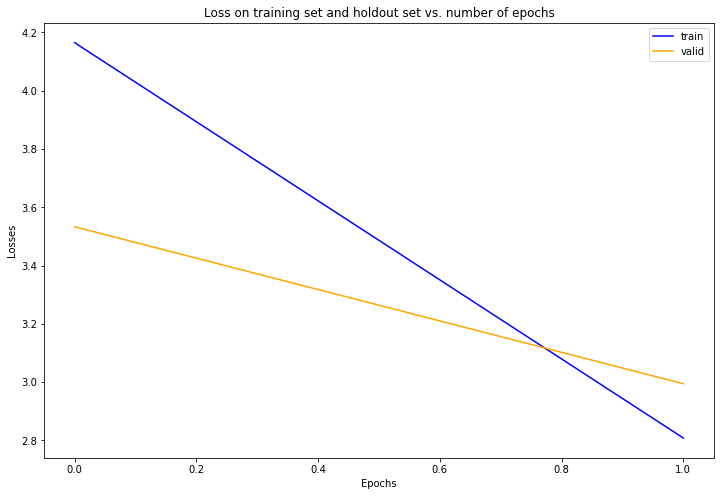

In [13]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Losses')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, epochs+1), training_losses,'b-',color="blue",label="train")
_=ax.plot(range(0, epochs+1), validation_losses,'b-',color="orange",label="valid")
plt.legend()
plt.title("Loss on training set and holdout set vs. number of epochs")

Text(0.5, 1.0, 'Accuracy on training set and holdout set vs. number of epochs')

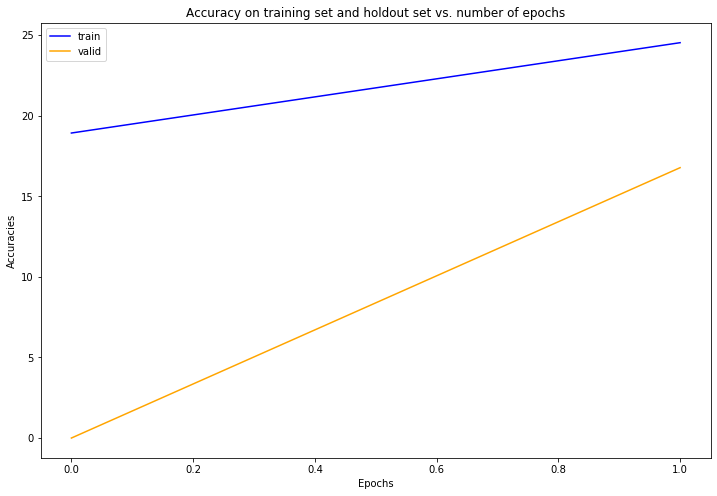

In [14]:
fig,ax = plt.subplots(figsize=(12,8))
ax.set_ylabel('Accuracies')
ax.set_xlabel('Epochs')
_=ax.plot(range(0, epochs+1), training_accuracies,'b-',color="blue",label="train")
_=ax.plot(range(0, epochs+1), validation_accuracies,'b-',color="orange",label="valid")
plt.legend()
plt.title("Accuracy on training set and holdout set vs. number of epochs")